<a href="https://colab.research.google.com/github/depresssed-kid/Glass-Classification/blob/main/GlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import yellowbrick.classifier as ybc
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.target import ClassBalance
from sklearn.metrics import classification_report

In [55]:
glass_df = pd.read_csv('glass_high_usability.csv')
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [56]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      136 non-null    float64
 1   Na      136 non-null    float64
 2   Mg      136 non-null    float64
 3   Al      136 non-null    float64
 4   Si      136 non-null    float64
 5   K       136 non-null    float64
 6   Ca      136 non-null    float64
 7   Ba      136 non-null    float64
 8   Fe      136 non-null    float64
 9   Type    136 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 10.8 KB


array([[<Axes: title={'center': 'RI'}>, <Axes: title={'center': 'Na'}>,
        <Axes: title={'center': 'Mg'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Si'}>,
        <Axes: title={'center': 'K'}>],
       [<Axes: title={'center': 'Ca'}>, <Axes: title={'center': 'Ba'}>,
        <Axes: title={'center': 'Fe'}>],
       [<Axes: title={'center': 'Type'}>, <Axes: >, <Axes: >]],
      dtype=object)

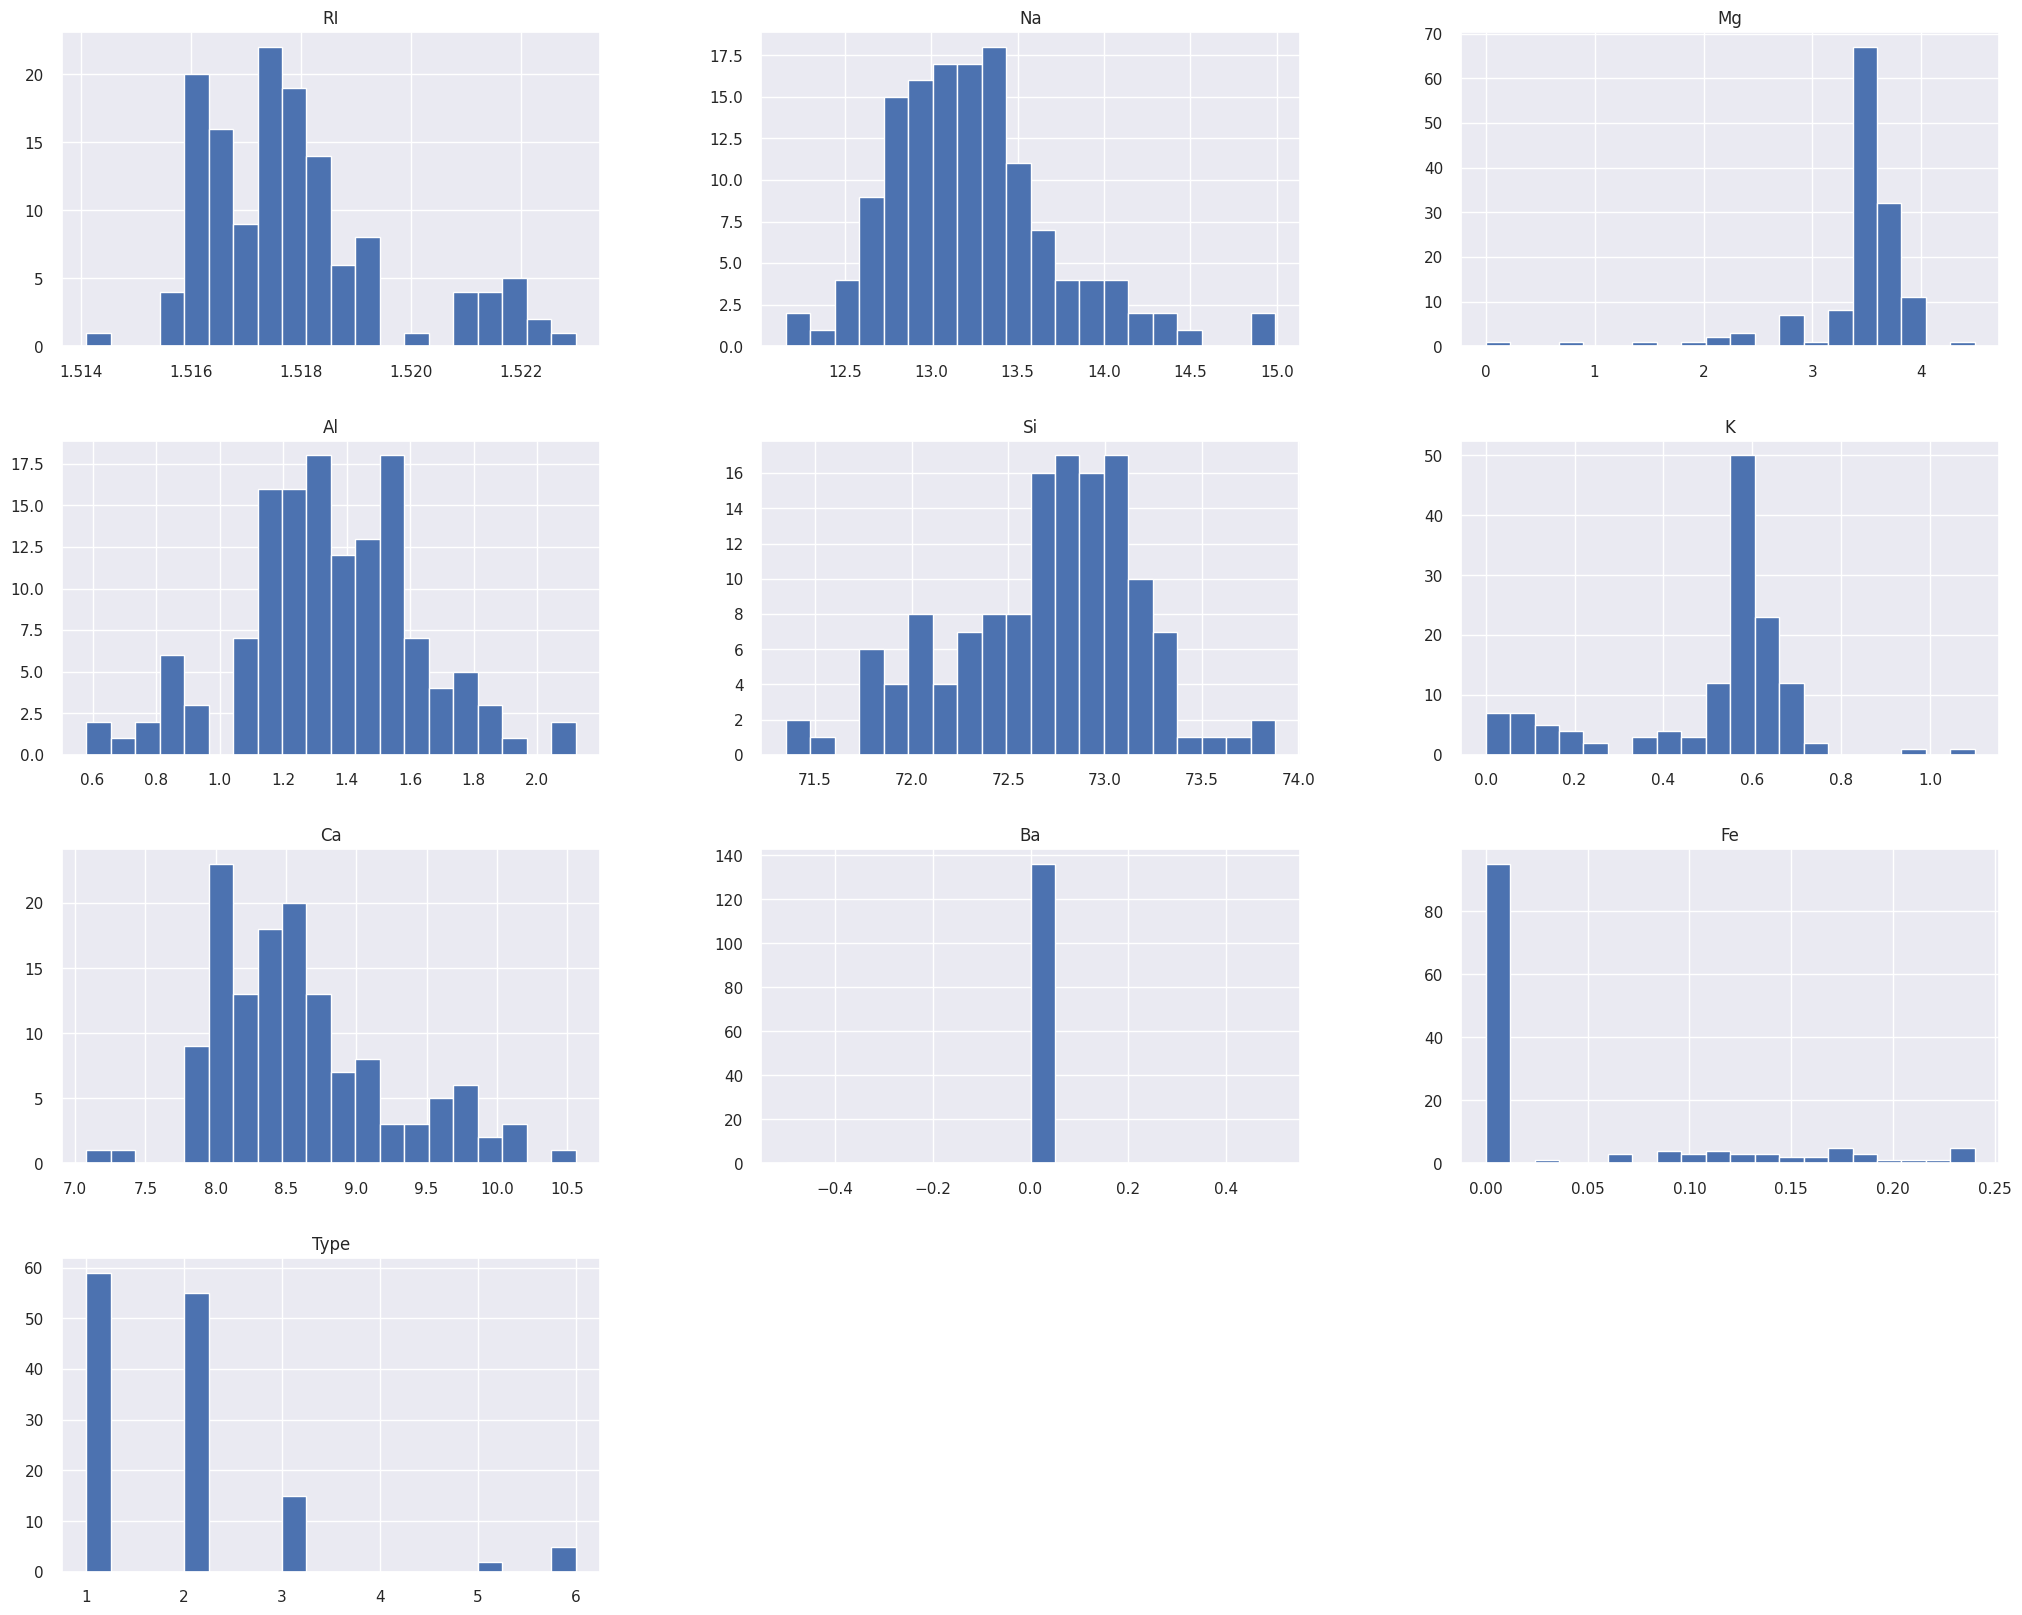

In [57]:
glass_df.hist(bins=20, figsize=(25, 20))

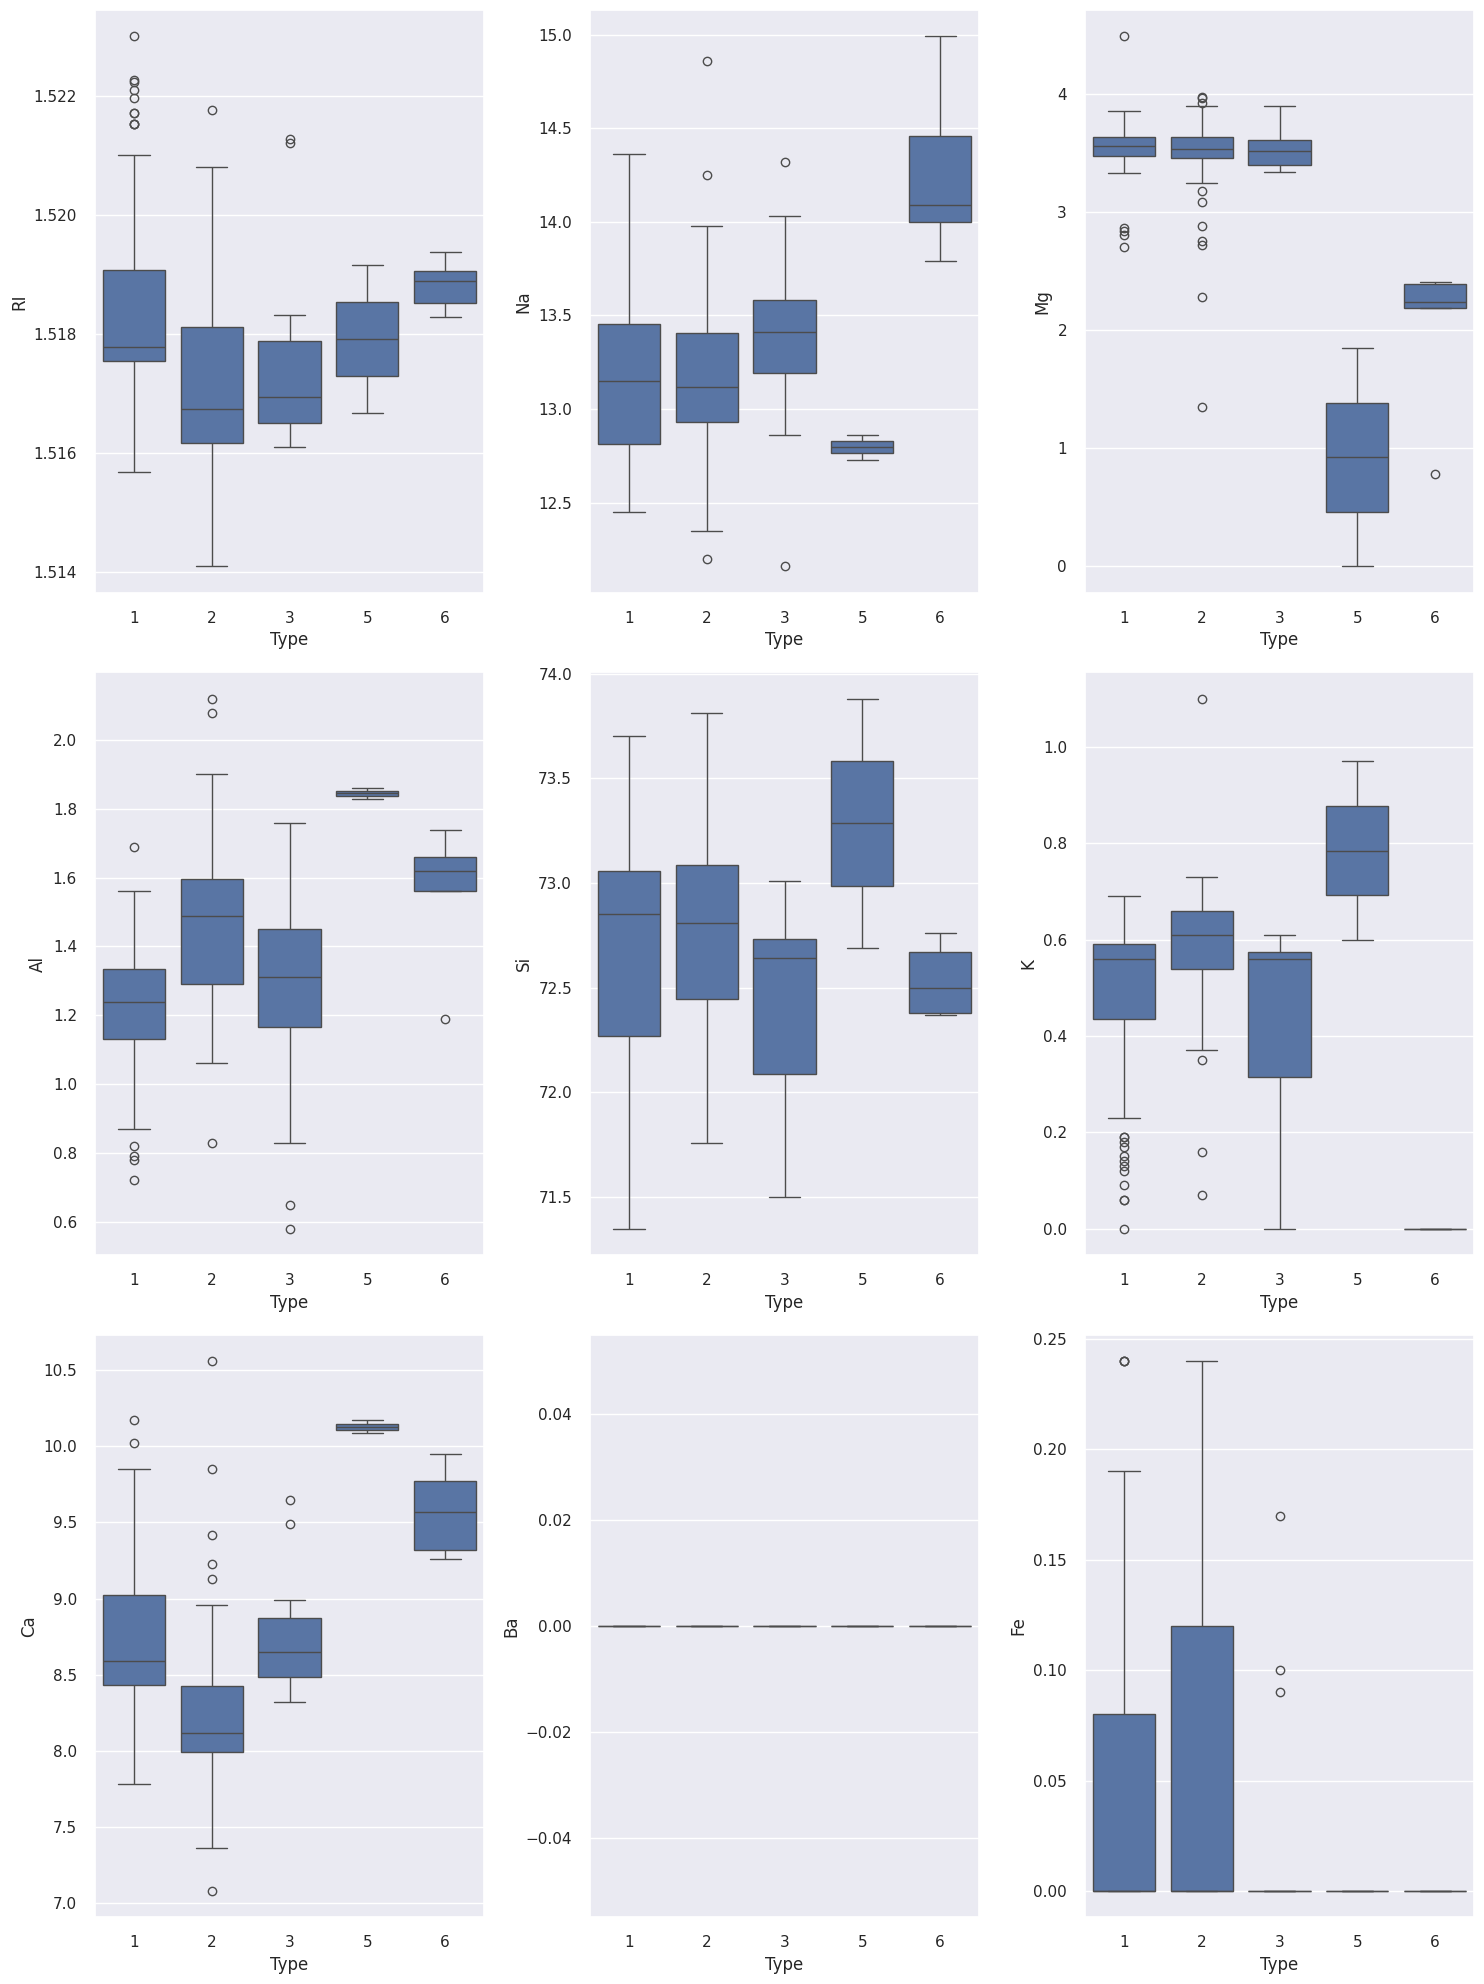

In [58]:
fig, axs = plt.subplots(3, 3, figsize=(15, 20))
axs = axs.flatten()
for i, col in enumerate(glass_df.columns.drop('Type')):
    sns.boxplot(x='Type', y=glass_df[col], data=glass_df, ax=axs[i])
plt.tight_layout()
plt.show()

Since the 'Ba' column has only one value, we assume that it is of no practical use.

<Axes: >

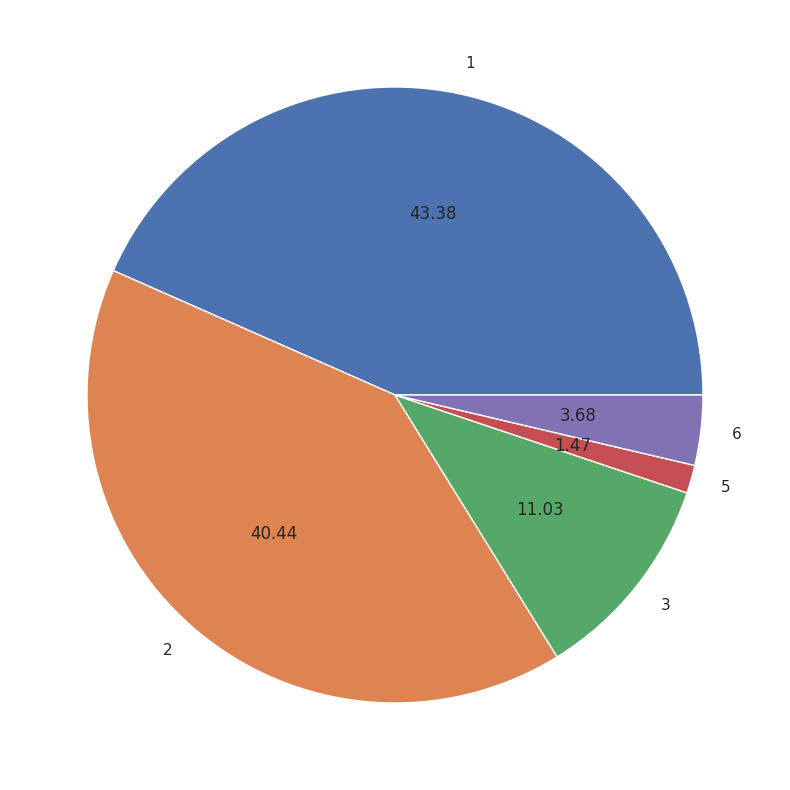

In [59]:
glass_df.groupby('Type').size().plot(kind='pie', autopct='%.2f')

In [60]:
glass_df = glass_df.drop("Ba",axis=1)

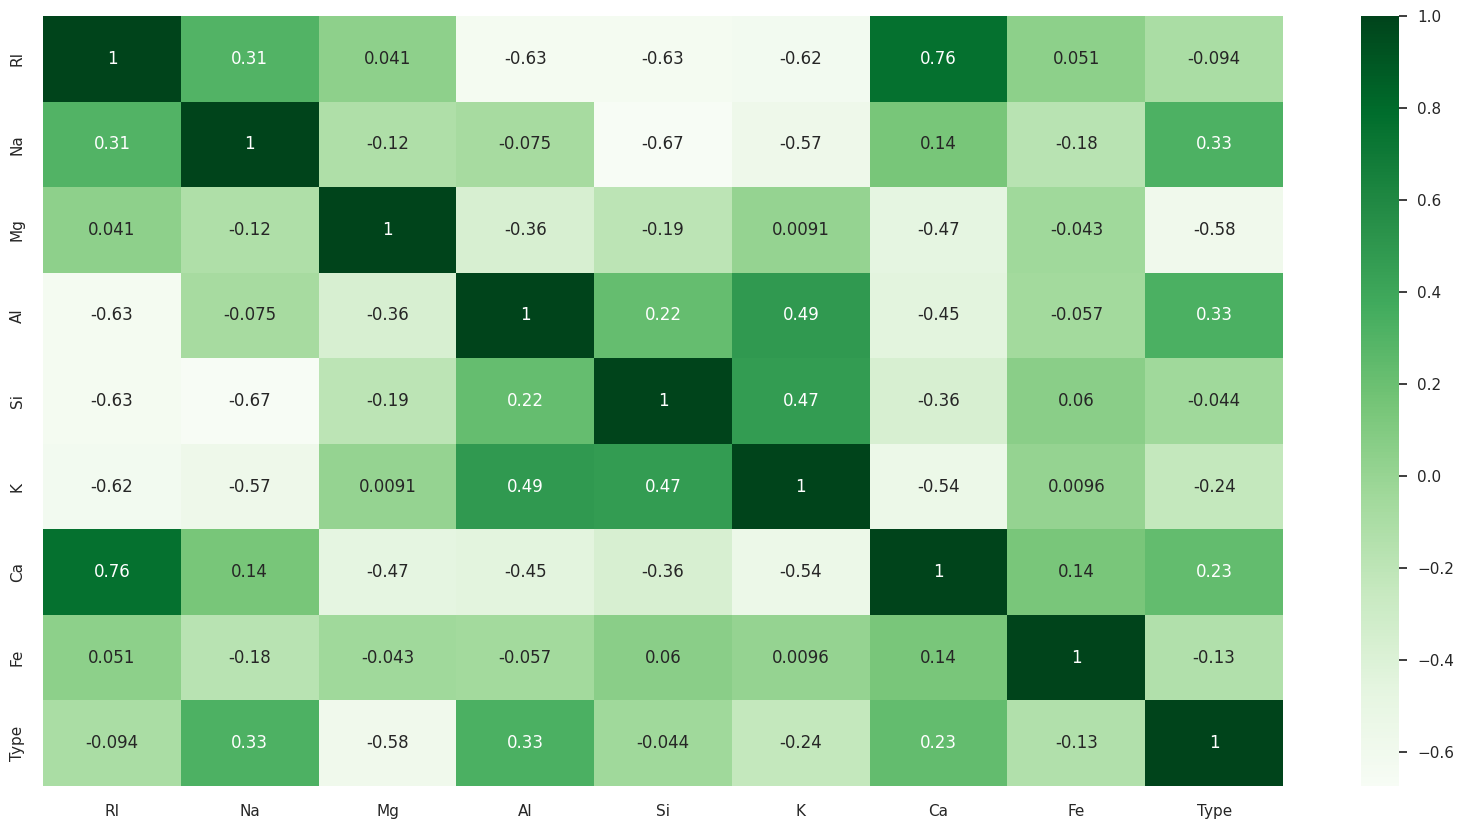

In [61]:
correlation_matrix = glass_df.corr()
sns.heatmap(correlation_matrix, cmap="Greens", annot=True)
plt.show()

Predictors have too much correlation between each other, this may be a sign of multicollinearity.

In [62]:
vif_data = [variance_inflation_factor(glass_df.values, i)
                          for i in range(len(glass_df.columns))]
vif_data

[803269.4213539981,
 14695.736978255669,
 1241.6709704676891,
 233.86488008991333,
 410618.8690381812,
 44.15697499301082,
 8568.397052487648,
 1.4777463598773444,
 7.619564752878066]

VIF shows an incredible level of multicollinearity (this prevents us from using linear models.)

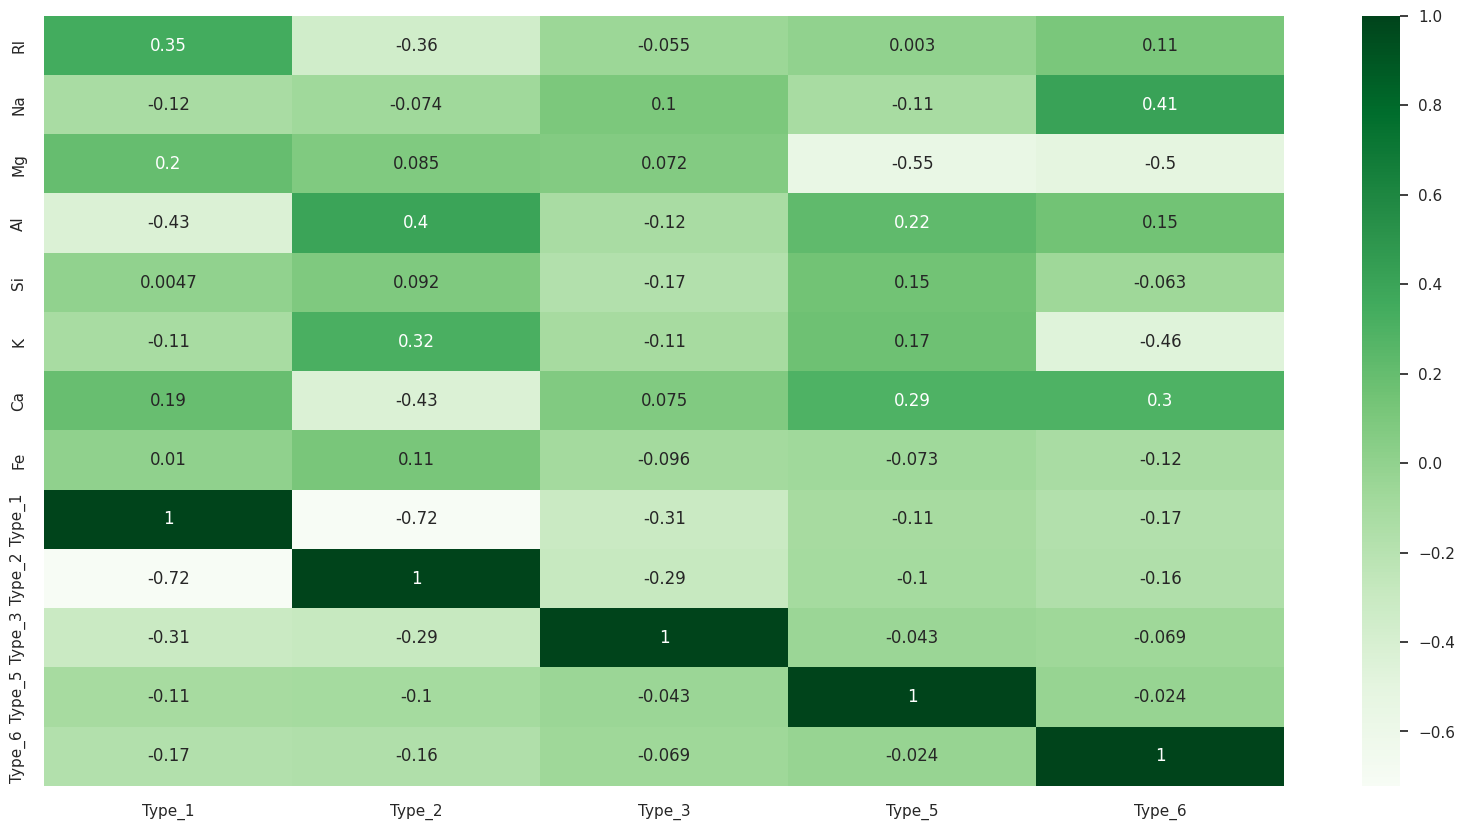

In [63]:
glass_df_4corr = pd.get_dummies(glass_df, columns=['Type'])
correlation_matrix = glass_df_4corr.corr()
sns.set(rc={"figure.figsize": (20, 10)})
sns.heatmap(correlation_matrix[['Type_1','Type_2','Type_3','Type_5','Type_6']], cmap="Greens", annot=True)
plt.show()

<Axes: >

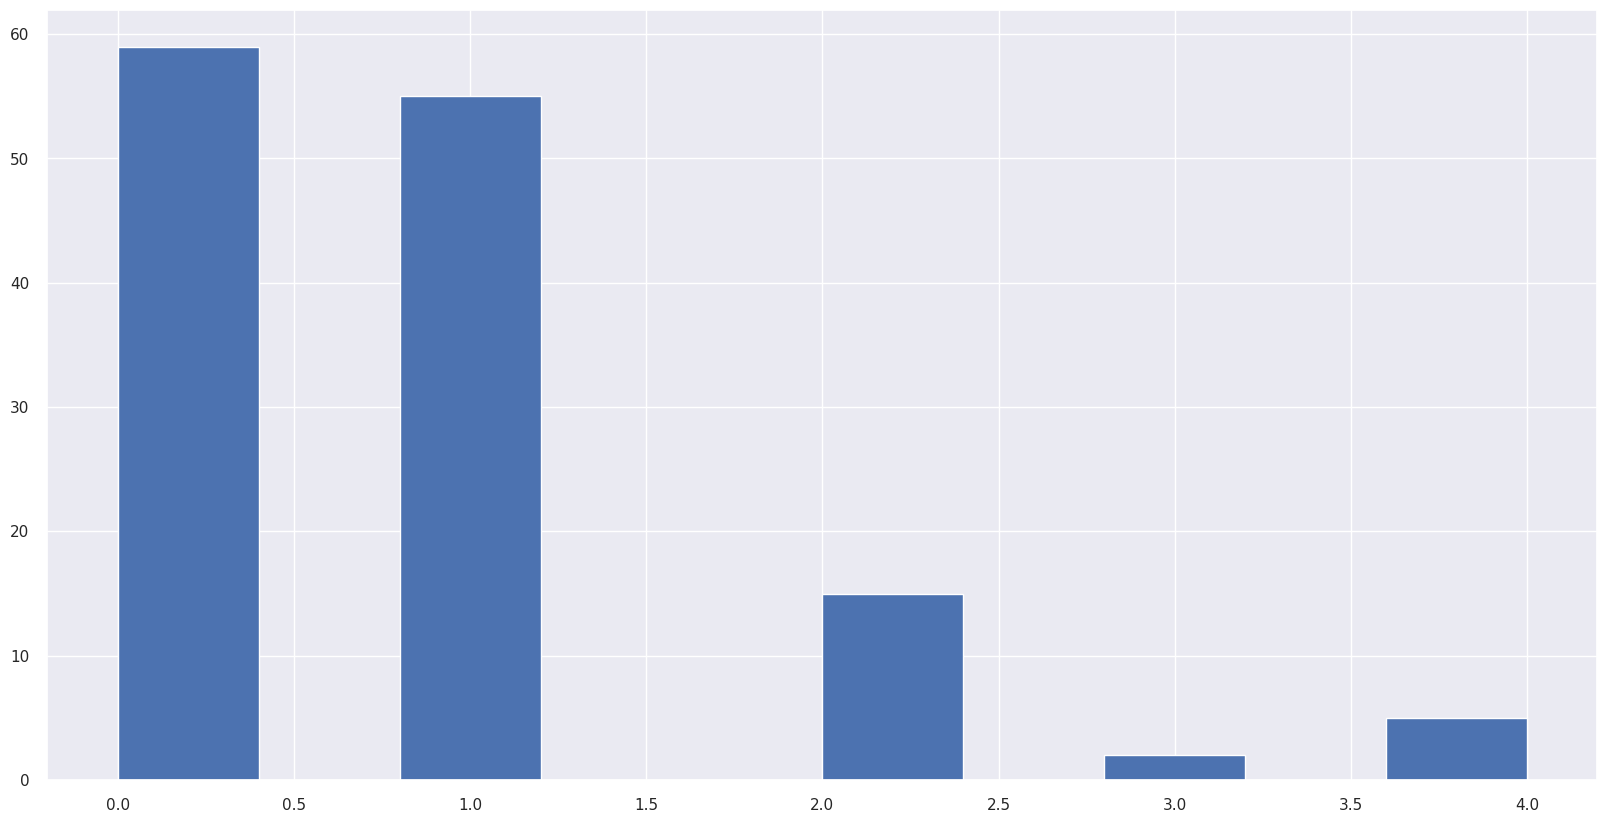

In [64]:
glass_df['Type'] = glass_df['Type'] -1
glass_df['Type'] = np.where(glass_df['Type']>=4,glass_df['Type']-1,glass_df['Type'])
X = glass_df.drop(['Type'], axis=1)
y = glass_df['Type']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

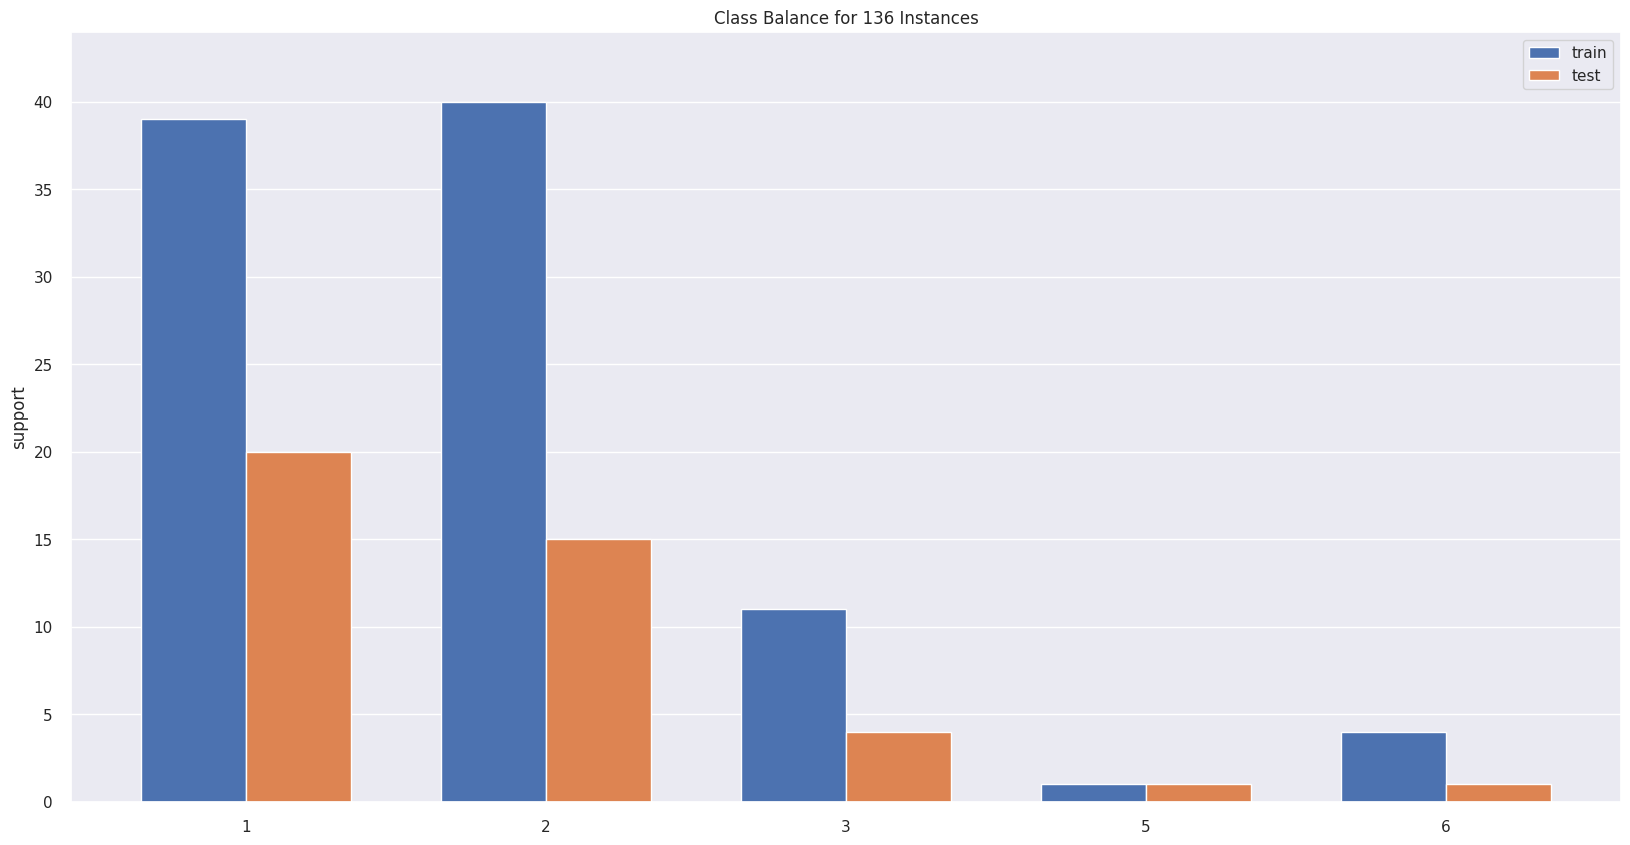

<Axes: title={'center': 'Class Balance for 136 Instances'}, ylabel='support'>

In [65]:
visualizer = ClassBalance(labels= [1,2,3,5,6])
visualizer.fit(y_train, y_test)
visualizer.poof()

**Due to the strong class imbalance, the 'accuracy' metric is not suitable for us.
To evaluate optimality, use 'weighted avg f1'**

In [100]:
#не получается использовать gridsearch для подбора параметров из-за класса в котором 1 элкмент
params = {'n_estimators': 500,
          'learning_rate': 0.1,
          'max_depth':10,
          'random_state':42}
xmodel = xgb.XGBClassifier(**params)
xmodel.fit(X_train, y_train)
x_pred = xmodel.predict(X_test)
report = classification_report(y_test, x_pred)
print('test :\n',report )

test :
               precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.65      0.87      0.74        15
           2       0.50      0.50      0.50         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.71        41
   macro avg       0.39      0.41      0.40        41
weighted avg       0.69      0.71      0.69        41



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [102]:
params = {
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bynode': 0.75,
    'max_depth': 10,
    'random_state': 42
}
xrfmodel = xgb.XGBRFClassifier(**params)
xrfmodel.fit(X_train, y_train)
xrf_pred = xrfmodel.predict(X_test)
report = classification_report(y_test, xrf_pred)
print('test :\n',report )

test :
               precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.59      0.87      0.70        15
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.66        41
   macro avg       0.28      0.31      0.29        41
weighted avg       0.62      0.66      0.63        41



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


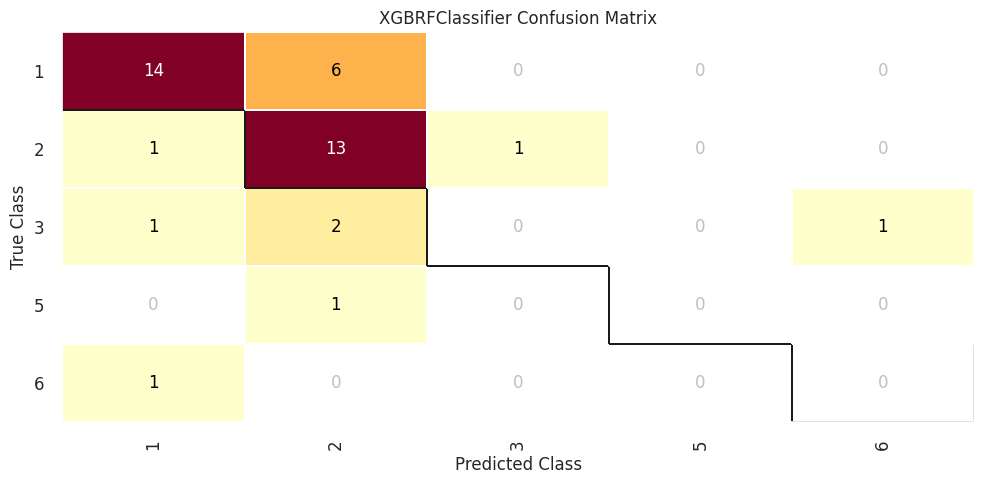

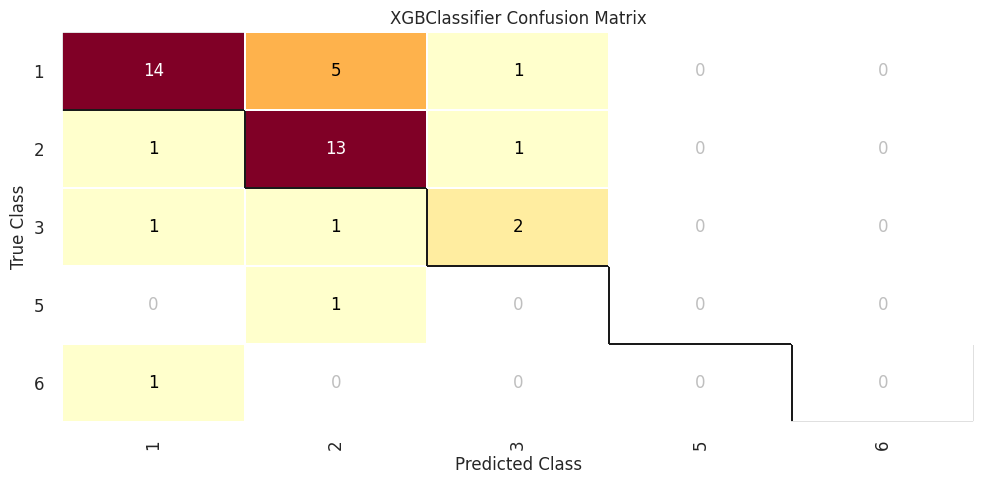

In [105]:
models = [xrfmodel,xmodel]
for model in models:
  sns.set(rc={"figure.figsize": (10, 5)})
  cm = ybc.ConfusionMatrix(
    model, classes=['1','2','3','5','6'])
  cm.fit(X_train, y_train)
  cm.score(X_test, y_test)
  cm.show()